In [ ]:
import gdown
import tarfile
import os
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from PIL import Image
import tensorflow as tf
from keras.regularizers import l2
import cv2 as cv
from keras.models import load_model
from tensorflow.keras.applications import DenseNet121
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.backend import expand_dims
from tensorflow import concat
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import TimeDistributed
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,Layer,Dropout,GRU
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import repeat
from sklearn.utils import shuffle
import nltk.translate.bleu_score as bleu
import warnings
warnings.filterwarnings('ignore')


print("done importing")

done importing


In [ ]:
url = 'https://drive.google.com/uc?id=1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k'
output = 'proccessed.pkl'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1U7D9lnjH-0CaXzhmua2rMtmdgS4DEH2k
To: /content/proccessed.pkl
100%|██████████| 58.1M/58.1M [00:00<00:00, 99.6MB/s]


'proccessed.pkl'

In [ ]:

url = 'https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7'
output = 'NLMCXR_png.tgz'
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7
From (redirected): https://drive.google.com/uc?id=1--clwDc2F3_CF6O4EB_BnDewFjHmFL_7&confirm=t&uuid=44f969ae-2719-4e7c-ae99-06b2c8a46f28
To: /content/NLMCXR_png.tgz
100%|██████████| 1.36G/1.36G [00:16<00:00, 81.5MB/s]


'NLMCXR_png.tgz'

In [ ]:

cwd = os.getcwd()
tf1 = tarfile.open('NLMCXR_png.tgz')
tf1.extractall(cwd+'/png/')


In [ ]:
data = pd.read_pickle('/content/proccessed.pkl')


In [ ]:
X_train, X_test = train_test_split(data.values , test_size = 0.2 )

In [ ]:
X_train.shape

(2669, 8)

In [ ]:
X_test.shape

(668, 8)

In [ ]:
X_train = X_train[:-13, :]
X_test = X_test[:-12, :]

In [ ]:
X_train.shape

(2656, 8)

In [ ]:
X_test.shape

(656, 8)

In [ ]:
data.columns


Index(['patient_id', 'image1', 'image2', 'findings', 'image_features',
       'findings_total', 'dec_ip', 'dec_op'],
      dtype='object')

In [ ]:

t1 = Tokenizer( filters='!"#$%&()*+,-/:;=?@[\\]^_`{|}~\t\n',oov_token='OOV')
t1.fit_on_texts(X_train[:,5])
vocab_size_imp = len(t1.word_index) + 1

dec_inp = t1.texts_to_sequences(X_train[:,6])

dec_inp = pad_sequences(dec_inp, maxlen=76, padding='post')

dec_inp_cv = t1.texts_to_sequences(X_test[:,6])

dec_inp_cv = pad_sequences(dec_inp_cv, maxlen=76, padding='post')

dec_op = t1.texts_to_sequences(X_train[:,7])

dec_op = pad_sequences(dec_op, maxlen=76, padding='post')

dec_op_cv = t1.texts_to_sequences(X_test[:,7])

dec_op_cv = pad_sequences(dec_op_cv, maxlen=76, padding='post')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

with open('t1.pickle', 'wb') as handle:
    pickle.dump(t1, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp -r /content/t1.pickle /content/drive/MyDrive

In [ ]:
vocab_size_imp


1839

In [ ]:
imp1 = {}
imp2 = {}
for key,value in t1.word_index.items():
  imp1[value] = key
  imp2[key] = value

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,units):
        super().__init__()
        self.units = units
        self.dense = Dense(self.units,name = 'Enc_dense')


    def call(self,img):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      #enc_out = self.maxpool(tf.expand_dims(img,axis = 2))
      enc_out = self.dense(img)
      return enc_out


    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      self.batch_size  = batch_size

      self.enc_h =tf.zeros((self.batch_size, self.units))

      #self.enc_c = tf.zeros((self.batch_size, self.lstm_size))
      return self.enc_h


In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,att_units):
    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()

    self.att_units = att_units

    self.w1 =  tf.keras.layers.Dense( self.att_units , name = 'w1')
    self.w2 =  tf.keras.layers.Dense( self.att_units,name = 'w2')
    self.v =  tf.keras.layers.Dense(1,name = 'v')

  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    self.decoder_hidden_state = decoder_hidden_state
    self.encoder_output = encoder_output


    self.decoder_hidden_state = tf.expand_dims(self.decoder_hidden_state,axis = 1)
    score = self.v(tf.nn.tanh(
              self.w1(self.decoder_hidden_state) + self.w2(self.encoder_output)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * self.encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector,attention_weights




In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units  ,att_units):

      # Initialize decoder embedding layer, LSTM and any other objects needed
      super().__init__()
      self.tar_vocab_size = tar_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.dec_emb = Embedding(tar_vocab_size,embedding_dim,trainable = True , name = 'dec_embb')
      self.dec_lstm = GRU(self.dec_units, return_state=True, return_sequences=True, name="Decoder_LSTM")
      self.dense   = Dense(self.tar_vocab_size, name = 'one_dec')
      self.attention=Attention( self.att_units)
      self.d1 = Dropout(0.3,name = 'd1')
      self.d2 = Dropout(0.3,name = 'd2')
      self.d3 = Dropout(0.3,name = 'd3')

  @tf.function
  def call(self,input_to_decoder, encoder_output, state_h):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    self.input_to_decoder = input_to_decoder
    self.encoder_output = encoder_output
    self.state_h = state_h

    #A
    target_embedd           = self.dec_emb (self.input_to_decoder)     #(batch_size,1,embedingdim)
    #B
    target_embedd = self.d1(target_embedd)

    context_vector,attention_weights=self.attention(self.state_h,self.encoder_output) #context vector shape = (batch_size,att_units)
    #C
    concated = tf.concat([  tf.expand_dims(context_vector, 1),target_embedd], -1)
    concated = self.d2(concated)

    #D
    lstm_output, hs      = self.dec_lstm(concated, initial_state=self.state_h)

    lstm_output = tf.reshape(lstm_output, (-1, lstm_output.shape[2]))
    lstm_output = self.d3(lstm_output)
    #E
    op = self.dense(lstm_output)
    #op = tf.squeeze(op,[1])
    return op,hs,attention_weights,context_vector



In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.att_units = att_units
      self.onestep = OneStepDecoder(self.out_vocab_size,self.embedding_dim ,self.input_length,self.dec_units,self.att_units)

    @tf.function
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state):


        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook

        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        all_outputs = tf.TensorArray(tf.float32,size =input_to_decoder.shape[1],name = 'output_arrays' )
        self.input_to_decoder = input_to_decoder
        self.encoder_output = encoder_output
        self.decoder_hidden_state = decoder_hidden_state

        for timestep in tf.range(input_to_decoder.shape[1]):
          op,hs,attention_weights,context_vector = self.onestep(self.input_to_decoder[:,timestep:timestep+1], self.encoder_output, self.decoder_hidden_state)
          self.decoder_hidden_state = hs
          all_outputs = all_outputs.write(timestep,op)
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        return all_outputs

In [ ]:
class encoder_decoder(tf.keras.Model):
  #def __init__(self,#params):
    #Intialize objects from encoder decoder
  def __init__(self,out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size,units):

        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        super().__init__()

        self.units = units
        self.out_vocab_size = out_vocab_size
        self.embedding_size_d = embedding_size_d
        self.lstm_size_d = lstm_size_d
        self.input_length_d = input_length_d
        self.batch_size = batch_size
        self.att_units = att_units

        self.encoder = Encoder(self.units)

        self.decoder = Decoder(out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units )
        #self.dense   = TimeDistributed(Dense(self.out_vocab_size, activation='softmax'))
        self.dense   = Dense(self.out_vocab_size,name = 'enc_dec_dense')



  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    self.inputs,self.outputs = data[0], data[1]
    print("="*20, "ENCODER", "="*20)
    self.encoder_h= self.encoder.initialize_states(self.batch_size)
    self.encoder_output = self.encoder(self.inputs)
    print("-"*27)
    print("ENCODER ==> OUTPUT SHAPE",self.encoder_output.shape)
    print("ENCODER ==> HIDDEN STATE SHAPE",self.encoder_h.shape)
    print("="*20, "DECODER", "="*20)
    output= self.decoder(self.outputs,self.encoder_output,self.encoder_h)
    print("-"*27)
    print("FINAL OUTPUT SHAPE",output.shape)
    print("="*50)
    return output





In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
  #out_vocab_size , embedding_size_d, input_length_d,lstm_size_d,att_units,batch_size)

In [ ]:
!mkdir checkpoint


In [ ]:
checkpoint_filepath = cwd + '/' + 'checkpoint' + '/'


In [ ]:
checkpoint_filepath


'/content/checkpoint/'

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    verbose = 1,
    mode='min',
    save_best_only=True)

In [ ]:
tf.keras.backend.clear_session()


In [ ]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,mode = 'min',verbose = 1,
                              patience=2, min_lr=0.0001)

In [ ]:
model_1 = encoder_decoder(vocab_size_imp,300,76,256,64,16,256)
optimizer = tf.keras.optimizers.Adam()
model_1.compile(optimizer=optimizer,loss=loss_function, metrics = "accuracy")

In [ ]:
train_inp = np.vstack(X_train[:,4]).astype(np.float64)  # Use np.float64 for double-precision floats
test_inp = np.vstack(X_test[:,4]).astype(np.float32)  # Use np.float32 for single-precision floats (if memory efficiency is a concern)


In [ ]:
model_1.fit([train_inp,dec_inp ],dec_op ,validation_data= ([test_inp, dec_inp_cv],dec_op_cv),batch_size= 16,epochs  = 40,callbacks=[reduce_lr,model_checkpoint_callback] , shuffle=True)

Epoch 1/40
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (16, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (16, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)
166/166 [==============================] - ETA: 0s - loss: 2.1975 - accuracy: 0.0219==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (16, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)

Epoch 1: val_loss improved from inf to 2.11398, saving model to /content/checkpoint/
==================== 

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 98s 559ms/step - loss: 2.1975 - accuracy: 0.0219 - val_loss: 2.1140 - val_accuracy: 0.0251 - lr: 0.0010
Epoch 2/40
166/166 [==============================] - ETA: 0s - loss: 1.9875 - accuracy: 0.0559
Epoch 2: val_loss improved from 2.11398 to 1.62600, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 102s 614ms/step - loss: 1.9875 - accuracy: 0.0559 - val_loss: 1.6260 - val_accuracy: 0.1115 - lr: 0.0010
Epoch 3/40
166/166 [==============================] - ETA: 0s - loss: 1.3403 - accuracy: 0.1549
Epoch 3: val_loss improved from 1.62600 to 1.15111, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 93s 559ms/step - loss: 1.3403 - accuracy: 0.1549 - val_loss: 1.1511 - val_accuracy: 0.1820 - lr: 0.0010
Epoch 4/40
166/166 [==============================] - ETA: 0s - loss: 1.0687 - accuracy: 0.1933
Epoch 4: val_loss improved from 1.15111 to 1.02183, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 100s 605ms/step - loss: 1.0687 - accuracy: 0.1933 - val_loss: 1.0218 - val_accuracy: 0.2030 - lr: 0.0010
Epoch 5/40
166/166 [==============================] - ETA: 0s - loss: 0.9564 - accuracy: 0.2109
Epoch 5: val_loss improved from 1.02183 to 0.96486, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 104s 627ms/step - loss: 0.9564 - accuracy: 0.2109 - val_loss: 0.9649 - val_accuracy: 0.2118 - lr: 0.0010
Epoch 6/40
166/166 [==============================] - ETA: 0s - loss: 0.8882 - accuracy: 0.2212
Epoch 6: val_loss improved from 0.96486 to 0.92743, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 95s 573ms/step - loss: 0.8882 - accuracy: 0.2212 - val_loss: 0.9274 - val_accuracy: 0.2203 - lr: 0.0010
Epoch 7/40
166/166 [==============================] - ETA: 0s - loss: 0.8375 - accuracy: 0.2289
Epoch 7: val_loss improved from 0.92743 to 0.90679, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 93s 559ms/step - loss: 0.8375 - accuracy: 0.2289 - val_loss: 0.9068 - val_accuracy: 0.2251 - lr: 0.0010
Epoch 8/40
166/166 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.2359
Epoch 8: val_loss improved from 0.90679 to 0.88599, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 98s 589ms/step - loss: 0.7973 - accuracy: 0.2359 - val_loss: 0.8860 - val_accuracy: 0.2287 - lr: 0.0010
Epoch 9/40
166/166 [==============================] - ETA: 0s - loss: 0.7660 - accuracy: 0.2397
Epoch 9: val_loss improved from 0.88599 to 0.87273, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 96s 578ms/step - loss: 0.7660 - accuracy: 0.2397 - val_loss: 0.8727 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 10/40
166/166 [==============================] - ETA: 0s - loss: 0.7371 - accuracy: 0.2455
Epoch 10: val_loss improved from 0.87273 to 0.86418, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 94s 568ms/step - loss: 0.7371 - accuracy: 0.2455 - val_loss: 0.8642 - val_accuracy: 0.2343 - lr: 0.0010
Epoch 11/40
166/166 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.2481
Epoch 11: val_loss improved from 0.86418 to 0.85547, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 95s 576ms/step - loss: 0.7132 - accuracy: 0.2481 - val_loss: 0.8555 - val_accuracy: 0.2370 - lr: 0.0010
Epoch 12/40
166/166 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.2527
Epoch 12: val_loss improved from 0.85547 to 0.84877, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 100s 604ms/step - loss: 0.6897 - accuracy: 0.2527 - val_loss: 0.8488 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 13/40
166/166 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.2555
Epoch 13: val_loss improved from 0.84877 to 0.84430, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 102s 614ms/step - loss: 0.6718 - accuracy: 0.2555 - val_loss: 0.8443 - val_accuracy: 0.2397 - lr: 0.0010
Epoch 14/40
166/166 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.2586
Epoch 14: val_loss improved from 0.84430 to 0.84236, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 94s 567ms/step - loss: 0.6559 - accuracy: 0.2586 - val_loss: 0.8424 - val_accuracy: 0.2407 - lr: 0.0010
Epoch 15/40
166/166 [==============================] - ETA: 0s - loss: 0.6409 - accuracy: 0.2607
Epoch 15: val_loss improved from 0.84236 to 0.84061, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 95s 572ms/step - loss: 0.6409 - accuracy: 0.2607 - val_loss: 0.8406 - val_accuracy: 0.2423 - lr: 0.0010
Epoch 16/40
166/166 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.2645
Epoch 16: val_loss improved from 0.84061 to 0.83551, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 101s 606ms/step - loss: 0.6265 - accuracy: 0.2645 - val_loss: 0.8355 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 17/40
166/166 [==============================] - ETA: 0s - loss: 0.6139 - accuracy: 0.2656
Epoch 17: val_loss improved from 0.83551 to 0.83519, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 98s 588ms/step - loss: 0.6139 - accuracy: 0.2656 - val_loss: 0.8352 - val_accuracy: 0.2445 - lr: 0.0010
Epoch 18/40
166/166 [==============================] - ETA: 0s - loss: 0.6012 - accuracy: 0.2678
Epoch 18: val_loss did not improve from 0.83519
166/166 [==============================] - 100s 605ms/step - loss: 0.6012 - accuracy: 0.2678 - val_loss: 0.8359 - val_accuracy: 0.2463 - lr: 0.0010
Epoch 19/40
166/166 [==============================] - ETA: 0s - loss: 0.5908 - accuracy: 0.2706
Epoch 19: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.

Epoch 19: val_loss did not improve from 0.83519
166/166 [==============================] - 92s 552ms/step - loss: 0.5908 - accuracy: 0.2706 - val_loss: 0.8368 - val_accuracy: 0.2450 - lr: 0.0010
Epoch 20/40
166/166 [==============================] - ETA: 0s - loss: 0.5732 - accuracy: 0.2744
Epoch 20: val_loss improved from 0.83519 to 0.83481, saving model to /content/checkpoint/
====

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 102s 613ms/step - loss: 0.5732 - accuracy: 0.2744 - val_loss: 0.8348 - val_accuracy: 0.2459 - lr: 8.0000e-04
Epoch 21/40
166/166 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.2758
Epoch 21: val_loss improved from 0.83481 to 0.82886, saving model to /content/checkpoint/
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (16, 76, 1839)


==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 93s 560ms/step - loss: 0.5646 - accuracy: 0.2758 - val_loss: 0.8289 - val_accuracy: 0.2470 - lr: 8.0000e-04
Epoch 22/40
166/166 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.2773
Epoch 22: val_loss did not improve from 0.82886
166/166 [==============================] - 93s 557ms/step - loss: 0.5553 - accuracy: 0.2773 - val_loss: 0.8295 - val_accuracy: 0.2468 - lr: 8.0000e-04
Epoch 23/40
166/166 [==============================] - ETA: 0s - loss: 0.5479 - accuracy: 0.2778
Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.

Epoch 23: val_loss did not improve from 0.82886
166/166 [==============================] - 90s 544ms/step - loss: 0.5479 - accuracy: 0.2778 - val_loss: 0.8340 - val_accuracy: 0.2475 - lr: 8.0000e-04
Epoch 24/40
166/166 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.2813
Epoch 24: val_loss did not improve from 0.82886
166/166 [=========================

==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)
==================== ENCODER ====================
---------------------------
ENCODER ==> OUTPUT SHAPE (None, 256)
ENCODER ==> HIDDEN STATE SHAPE (16, 256)
==================== DECODER ====================
---------------------------
FINAL OUTPUT SHAPE (None, 76, 1839)


166/166 [==============================] - 95s 571ms/step - loss: 0.5015 - accuracy: 0.2887 - val_loss: 0.8276 - val_accuracy: 0.2502 - lr: 4.0960e-04
Epoch 30/40
166/166 [==============================] - ETA: 0s - loss: 0.4972 - accuracy: 0.2895
Epoch 30: val_loss did not improve from 0.82762
166/166 [==============================] - 90s 538ms/step - loss: 0.4972 - accuracy: 0.2895 - val_loss: 0.8341 - val_accuracy: 0.2506 - lr: 4.0960e-04
Epoch 31/40
166/166 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.2896
Epoch 31: ReduceLROnPlateau reducing learning rate to 0.00032768002711236477.

Epoch 31: val_loss did not improve from 0.82762
166/166 [==============================] - 86s 519ms/step - loss: 0.4933 - accuracy: 0.2896 - val_loss: 0.8356 - val_accuracy: 0.2511 - lr: 4.0960e-04
Epoch 32/40
166/166 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.2909
Epoch 32: val_loss did not improve from 0.82762
166/166 [========================

In [ ]:
model_1.load_weights(checkpoint_filepath)


In [ ]:
#https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/
#https://github.com/vysakh10/Medical-Report-Generation-using-Deep-Learning/blob/master/Attention_Onestep_Mod.ipynb
def beam(sentence):
  """ Thi function predicts the sentence using beam search """

  initial_state=model_1.layers[0].initialize_states(1)
  encoder_output= model_1.layers[0](sentence)
  result = ''

  sequences = [['<start>' ,initial_state, 0]]

  decoder_hidden_state = initial_state

  #cur_vec = np.ones((1, 1)) * imp2['<start>']
  #cur_vec = np.array([[1]])
  finished_seq = []
  beam_width = 3

  for i in range(76):
    all_candidates = []
    new_seq = []
    for s in sequences:

      cur_vec = np.reshape(imp2[s[0].split(" ")[-1]],(1,1))
      decoder_hidden_state = s[1]
      op,hs,attention_weights,context_vector = model_1.layers[1].onestep(cur_vec, encoder_output, decoder_hidden_state)
      op = tf.nn.softmax(op)
      top3 = np.argsort(op).flatten()[-beam_width:]
      for t in top3:

         candidates = [s[0] + ' '+ imp1[t], hs,s[2]-np.log(np.array(op).flatten()[t])]
         all_candidates.append(candidates)
    sequences = sorted(all_candidates, key = lambda l: l[2])[:beam_width]

    count = 0
    for s1 in sequences:
      if s1[0].split(" ")[-1] == '<end>':


        s1[2] = s1[2]/len(s1[0])   # normalized
        finished_seq.append([s1[0], s1[1],s1[2]])
        count+=1
      else:

        new_seq.append([s1[0], s1[1],s1[2]])

    beam_width -= count
    sequences = new_seq
    if not sequences:
      break
    else:
      continue

  if len(finished_seq) >0:
    sequences = finished_seq[-1]
    return sequences[0]
  else:
    return new_seq[-1][0]


In [ ]:
data.columns


Index(['patient_id', 'image1', 'image2', 'findings', 'image_features',
       'findings_total', 'dec_ip', 'dec_op'],
      dtype='object')

In [ ]:
num = 16 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
# img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)
# img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)


Original Sentence is :  <start> and lateral chest eamination was obtained. the heart silhouette and mediastinal contours are not enlarged. lungs demonstrate left lower lobe air space opacity with atelectasis without significant change. there is no effusion or pneumothora.
Predicted Sentence is :  <start> the lungs are clear. there is no pleural effusion or pneumothora. the heart is not significantly enlarged. there are atherosclerotic changes of the aorta. arthritic changes of the skeletal structures are noted. <end>


In [ ]:
num = 160 #random test sample
im_o = np.vstack(X_test[:,4][num]).astype(float)
tex_o = X_test[:,6][num]

print("Original Sentence is : " , tex_o)
print("Predicted Sentence is : ",beam(im_o))
# img = cv2.imread(X_test[:,1][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)
# img = cv2.imread(X_test[:,2][num], cv2.IMREAD_UNCHANGED)
# cv2_imshow(img)


Original Sentence is :  <start> the cardiomediastinal silhouette and pulmonary vasculature are within normal limits in size. there is a thin right apical pneumothora measuring approimately mm in thickness. there is etensive subcutaneous emphysema in the right chest wall and neck. there are fractures of the right anterior th through th anterior ribs with mild displacement. additional fractures cannot entirely be ecluded. there is mild streaky airspace disease in the right lung base. left lung is clear. there is a small hiatal hernia. there is an intrathecal catheter terminating in the lower thoracic spine.
Predicted Sentence is :  <start> the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothora is seen. <end>


In [ ]:
count = set()
for num in range(650):
    im_o = np.vstack(X_test[:, 4][num]).astype(float)
    tex_o = X_test[:, 6][num]

    print("Sample Number:", num)
    print("Original Sentence is:", tex_o)
    print("Predicted Sentence is:", beam(im_o))
    print("The X-Rays are:")

    img1 = cv2.imread(X_test[:, 1][num], cv2.IMREAD_UNCHANGED)
    img2 = cv2.imread(X_test[:, 2][num], cv2.IMREAD_UNCHANGED)

    count.add(beam(im_o))
    print(count)
    # cv2_imshow(img1)
    # cv2_imshow(img2)
    print("\n" + "-"*50 + "\n")

Streaming output truncated to the last 5000 lines.
Sample Number: 25
Original Sentence is: <start> and lateral chest eamination was obtained. the heart silhouette is normal in size and contour. aortic appear unremarkable. lungs demonstrate no acute findings. there is no effusion or pneumothora. no displaced rib fracture visualized.
Predicted Sentence is: <start> the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothora. osseous structures are within normal limits for patient age. <end>
The X-Rays are:
{'<start> the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothora. osseous structures are within normal limits for patient age. <end>', '<start> the lungs are clear. there is no pleural effusion or pneumothora. the heart is not signifi

In [ ]:
len(X_test)

650

In [ ]:
c = set()
for num in range(650):
    im_o = np.vstack(X_train[:, 4][num]).astype(float)
    tex_o = X_test[:, 6][num]
    if(num%100 == 0):
      print("Sample Number:", num)
    # print("Sample Number:", num)
    # print("Original Sentence is:", tex_o)
    # print("Predicted Sentence is:", beam(im_o))
    # print("The X-Rays are:")

    # img1 = cv2.imread(X_test[:, 1][num], cv2.IMREAD_UNCHANGED)
    # img2 = cv2.imread(X_test[:, 2][num], cv2.IMREAD_UNCHANGED)

    c.add(beam(im_o))
    # print(count)
    # cv2_imshow(img1)
    # cv2_imshow(img2)
    # print("\n" + "-"*50 + "\n")

Sample Number: 0
Sample Number: 100
Sample Number: 200
Sample Number: 300
Sample Number: 400
Sample Number: 500
Sample Number: 600


In [ ]:
len(c)

51

In [ ]:
#https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
b1 = 0
b2 = 0
b3 = 0
b4 = 0


for i in range(X_test.shape[0]):
  im_o = np.vstack(X_test[:,4][i]).astype(float)
  pred = beam(im_o)
  org= X_test[:,5][i]




  b1 =  b1 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(1, 0, 0, 0))
  b2 =  b2 + bleu.sentence_bleu([org.split()], pred.split(),weights=(0.5, 0.5, 0, 0))
  b3 =  b3 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.33, 0.33, 0.33, 0))
  b4 =  b4 + bleu.sentence_bleu([org.split()], pred.split() ,weights=(0.25, 0.25, 0.25, 0.25))



print("Bleu1 score is : ",b1/X_test.shape[0])
print("Bleu2 score is : ",b2/X_test.shape[0])
print("Bleu3 score is : ",b3/X_test.shape[0])
print("Bleu4 score is : ",b4/X_test.shape[0])


Bleu1 score is :  0.33079565892788104
Bleu2 score is :  0.17626994529882953
Bleu3 score is :  0.10189979924309743
Bleu4 score is :  0.050506875426319556


In [ ]:
model_1.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  524544    
                                                                 
 decoder (Decoder)           multiple                  1676309   
                                                                 
 enc_dec_dense (Dense)       multiple                  0 (unused)
                                                                 
Total params: 2200853 (8.40 MB)
Trainable params: 2200853 (8.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


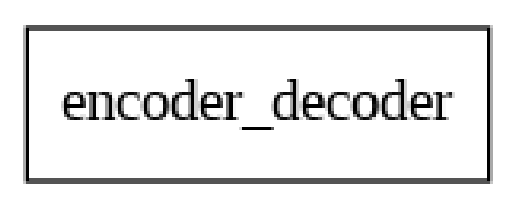

In [ ]:
plot_model(model_1, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the model architecture
img = mpimg.imread('model_architecture.png')
imgplot = plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.show()
